# 🚗 Car Prices ETL Pipeline

## 📝 Objective

This mini-project implements a simple yet functional **ETL process** (Extract, Transform, Load) — a key component of a **Data Engineer’s** work.

- The source data on used car prices is provided in various formats: **CSV**, **JSON**, and **XML**.  
- The task is to extract the data, convert it into a unified tabular format, and prepare it for saving in a final CSV file.

---

## ⚙️ Process Overview

- **Extract**  
  Automatic collection of data from all `.csv`, `.json`, and `.xml` files in the working directory.

- **Transform**  
  Data standardization: applying proper data types and rounding price values.

- **Load**  
  Saving the final DataFrame into `transformed_data.csv`.  
  Logging each processing step into `log_file.txt`.

---

## 💡 Practical Relevance

This project demonstrates how to work with **heterogeneous data sources**, apply a **functional approach**, and use **logging** — all of which are crucial aspects of real-world ETL pipelines.

It can serve as a **basic template for future projects** involving external data sources.

---

Next comes the step-by-step implementation: importing libraries, extracting, transforming, and loading the data.


## Step 1. Importing Libraries and Setting Up Variables

To implement the ETL process in this project, we use the following standard and third-party Python libraries:

- **pandas** — a library for working with tabular data. It is used for reading CSV and JSON files, transforming data, and creating the final DataFrame.
- **glob** — a module for finding all files in a directory that match a specific pattern (e.g., `*.csv`, `*.json`, `*.xml`). It enables automatic discovery and processing of data sources.
- **xml.etree.ElementTree** — a built-in module for parsing XML files. It allows extracting data from hierarchical XML structures.
- **datetime** — a module for handling date and time. It is used to add timestamps to the log file that tracks each ETL step.

All of these libraries are included in Python’s standard distribution, except for `pandas`, which can be installed using:


In [28]:
%pip install pandas 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


The next step is to import the required libraries and set up the global variables.


In [29]:
import pandas as pd                   # Working with tabular data (DataFrame)
import glob                           # Finding all files matching a pattern (*.csv, *.json, *.xml)
import xml.etree.ElementTree as ET    # Parsing and working with XML structure

from datetime import datetime         # Adding timestamps to the log
import matplotlib.pyplot as plt       # For data visualization


To ensure the correct execution of the ETL script, two global file paths are defined:

- `log_file.txt` — a file for writing execution logs. It will store timestamps and each ETL stage in sequence.
- `transformed_data.csv` — the final file where the combined and transformed dataset will be saved, ready for database loading or further analysis.

These variables are used in all key functions of the project: logging, data loading, and saving results.


In [30]:
# === VARIABLES ===
log_file = "output/log_file.txt"             # File to log the progress of the ETL process
target_file = "output/transformed_data.csv"  # Final CSV file with the transformed data


## Step 2. Logging Function

To track the progress of the ETL process, the project includes a `log_progress()` function. It writes messages to the `log_file.txt`, adding a timestamp to each entry.

This approach helps to:

- Verify which steps have already been executed  
- Debug errors or unexpected behavior  
- Maintain an execution history (e.g., when running the script on a schedule)


In [31]:
def log_progress(message):
    timestamp_format = '%Y-%b-%d-%H:%M:%S'      # Timestamp format, e.g. 2025-Jul-26-19:45:04
    now = datetime.now()                        # Get the current time
    timestamp = now.strftime(timestamp_format)  # Format the time as a string
    with open(log_file, "a") as f:              # Open the log file in append mode
        f.write(f"{timestamp},{message}\n")     # Write the timestamp and message to the file


## Step 3. Data Extraction

At this stage, data is automatically loaded from files in ***CSV***, ***JSON***, and ***XML*** formats.  
A separate function is used for each format, returning a pandas ***DataFrame*** structure.

This modular approach improves code readability and makes it easy to adapt solutions for other projects or data sources.


### 3.1. Extracting Data from CSV

The first function, `extract_from_csv()`, is responsible for extracting data from **CSV** (comma-separated values) files.

It uses `pandas.read_csv()` to load the file content into a **DataFrame** — a tabular structure that is ideal for further processing and merging of data.

This approach makes it easy to scale the process across multiple files by automating data extraction.


In [32]:
def extract_from_csv(file_to_process):
    return pd.read_csv(file_to_process)  # Reading a CSV file into a DataFrame using pandas


### 3.2. Extracting Data from JSON

The `extract_from_json()` function is used to process files in the **JSON Lines** format (one JSON object per line).

By using the `lines=True` parameter, the `pandas.read_json()` method correctly reads the data line by line into individual records. This format is commonly used for storing logs, data streams, and system exports.

The function returns a **DataFrame**, similar to the CSV data extraction.


In [33]:
def extract_from_json(file_to_process):
    # Reads a JSON file line by line in JSON Lines format (each line is a separate JSON object)
    return pd.read_json(file_to_process, lines=True)


### 3.3. Extracting Data from XML

The `extract_from_xml()` function handles reading and parsing data from **XML files**.  
Unlike CSV and JSON, XML requires a step-by-step traversal of elements.

The project uses the `ElementTree` module from Python's standard library to:

- parse the XML file;
- get the root element;
- extract values from the `<car_model>`, `<year_of_manufacture>`, `<price>`, and `<fuel>` tags inside each item.

Each data row is added to a predefined **DataFrame** with the necessary columns.  
This approach simplifies working with XML and makes the code easier to reuse for more complex XML structures in the future.


In [34]:
def extract_from_xml(file_to_process):
    # Create an empty DataFrame with predefined columns and data types
    # Using pd.Series(dtype=...) to explicitly define the structure
    dataframe = pd.DataFrame({
        "car_model": pd.Series(dtype="str"),            # string
        "year_of_manufacture": pd.Series(dtype="int"),  # integer
        "price": pd.Series(dtype="float"),              # float
        "fuel": pd.Series(dtype="str")                  # string
    })

    # Load and parse the XML file
    tree = ET.parse(file_to_process)    # create XML tree object
    root = tree.getroot()               # get root element of the XML structure

    # Iterate over each item (e.g., <car>) within the root
    for i in root:
        # Extract values from sub-elements of the current element
        car_model = i.find("car_model").text
        year_of_manufacture = int(i.find("year_of_manufacture").text)
        price = float(i.find("price").text)
        fuel = i.find("fuel").text

        # Build a dictionary from the extracted values
        row = {
            "car_model": car_model,
            "year_of_manufacture": year_of_manufacture,
            "price": price,
            "fuel": fuel
        }

        # Append the new row to the DataFrame
        dataframe.loc[len(dataframe)] = row

    # Return the final DataFrame with data extracted from XML
    return dataframe


## Step 4. Merging All Data

The `extract()` function consolidates data extraction from all supported formats: **CSV**, **JSON**, and **XML**. It also:

- creates an empty typed DataFrame with the required columns;
- uses the `glob` module to iterate through all files in the working directory;
- calls the appropriate function depending on the file format;
- merges the extracted data into a single final DataFrame;
- skips the final CSV file from processing to avoid recursion.

This approach allows automatic processing of entire folders with mixed file types without relying on specific filenames.


In [35]:
def extract():
    # Create an empty DataFrame with predefined columns and data types
    extracted_data = pd.DataFrame({
        "car_model": pd.Series(dtype="str"),               # Car brand/model
        "year_of_manufacture": pd.Series(dtype="int"),     # Year of manufacture
        "price": pd.Series(dtype="float"),                 # Price
        "fuel": pd.Series(dtype="str")                     # Fuel type
    })

    # === Extract data from CSV files ===
    for csvfile in glob.glob("data/*.csv"):                     # Loop through all .csv files in the current directory
        if csvfile != target_file:                         # Skip the final output file to avoid recursive processing
            new_data = extract_from_csv(csvfile)           # Extract data using extract_from_csv()
            if not new_data.empty:                         # Only process if the result is not empty
                # Append to the main DataFrame
                # ignore_index=True resets row indices (0 to N-1) after concatenation
                extracted_data = pd.concat([extracted_data, new_data], ignore_index=True)

    # === Extract data from JSON files ===
    for jsonfile in glob.glob("data/*.json"):                   # Loop through all .json files
        new_data = extract_from_json(jsonfile)             # Extract data from file
        if not new_data.empty:                           # Skip empty results
            extracted_data = pd.concat([extracted_data, new_data], ignore_index=True)

    # === Extract data from XML files ===
    for xmlfile in glob.glob("data/*.xml"):                     # Loop through all .xml files
        new_data = extract_from_xml(xmlfile)               # Extract data from file
        if not new_data.empty:                           # Skip empty results
            extracted_data = pd.concat([extracted_data, new_data], ignore_index=True)

    return extracted_data                                   # Return the merged DataFrame


## Step 5. Data Transformation

The `transform()` function performs a basic transformation:  
- **rounding prices to two decimal places** in the `price` column.

This step is important because it:

- removes unnecessary precision (e.g., values with 10 decimal places);
- converts prices into a format commonly used in reports, databases, and user interfaces.

The function returns the updated DataFrame, ready for saving.


In [36]:
def transform(data):
    # Transform the 'price' column by rounding values to two decimal places
    data['price'] = round(data['price'], 2)
    return data  # Return the transformed DataFrame


## Step 6. Saving the Result

The final stage of the ETL pipeline is saving the transformed data.

The `load_data()` function exports the final **DataFrame** to a CSV file specified by the `target_file` variable.  
The parameter `index=False` ensures that the DataFrame index is not saved as a separate column — which is useful when importing the data into a database.

The resulting `transformed_data.csv` file can be used as a ready-to-go dataset for analysis, visualization, or storage in a data warehouse.


In [37]:
def load_data(target_file, transformed_data):
    # Save the transformed data to a CSV file without including the index
    transformed_data.to_csv(target_file, index=False)


## Step 7. Running the ETL Pipeline and Logging the Execution Flow

The full ETL cycle is executed below — from logging the start to saving the final result:

1. **Initialization**: a "start" entry is written to the log
2. **Extraction**: data is loaded from all CSV, JSON, and XML files
3. **Transformation**: price values are rounded to two decimal places
4. **Loading**: the consolidated dataset is saved to a CSV file
5. **Logging**: each step is recorded with a timestamp in `log_file.txt`

Each stage is not only executed but also documented — which is important for reproducibility, debugging, and future automation.

The `print()` output is used to visually inspect the transformed data before saving.


In [38]:
# === RUNNING THE ETL PIPELINE ===
log_progress("ETL Job Started")

# Extract phase
log_progress("Extract phase Started")
extracted_data = extract()
log_progress("Extract phase Ended")

# Transform phase
log_progress("Transform phase Started")
transformed_data = transform(extracted_data)
print("Transformed Data:")
print(transformed_data)
log_progress("Transform phase Ended")

# Load phase
log_progress("Load phase Started")
load_data(target_file, transformed_data)
log_progress("Load phase Ended")

# Completion
log_progress("ETL Job Ended")


Transformed Data:
        car_model  year_of_manufacture     price    fuel
0            ritz                 2014   5000.00  Petrol
1             sx4                 2013   7089.55  Diesel
2            ciaz                 2017  10820.90  Petrol
3         wagon r                 2011   4253.73  Petrol
4           swift                 2014   6865.67  Diesel
..            ...                  ...       ...     ...
85          camry                 2006   3731.34  Petrol
86   land cruiser                 2010  52238.81  Diesel
87  corolla altis                 2012   8805.97  Petrol
88     etios liva                 2013   5149.25  Petrol
89        etios g                 2014   7089.55  Petrol

[90 rows x 4 columns]


---

## ✅ Summary

This mini-project implements a complete ETL process using Python:

🔹 **Extraction:** Data was successfully loaded from CSV, JSON, and XML files  
🔹 **Transformation:** Price values were rounded to two decimal places  
🔹 **Loading:** The combined result was saved to `transformed_data.csv`  
📝 The entire process was logged in the file `log_file.txt`

This project demonstrates how to automate the processing of heterogeneous data sources and prepare them for further analysis or storage.

---
**This ETL pipeline** serves as a solid starting point for building more advanced ETL processes involving various types of input data.  
**Next, we'll use the resulting dataset to perform a simple but insightful visual analysis.**


## 📊 Analysis: Which Cars Are the Most Expensive?

After completing the ETL process, we now have a clean and structured dataset ready for analysis.

Let’s begin with a simple but insightful question:  
**Which car brands have the highest average price on the used market?**

To answer this, we will:
- Extract the brand name from the car model
- Calculate the average price for each brand
- Create a chart showing the top 10 most expensive brands and save it


Top 10 car brands by average price:
brand
land        52238.81
fortuner    28671.64
innova      19773.63
vitara      13805.97
ciaz        11152.57
ertiga      10111.94
corolla      9792.29
s            9701.49
baleno       8731.34
ignis        7313.43
Name: price, dtype: float64


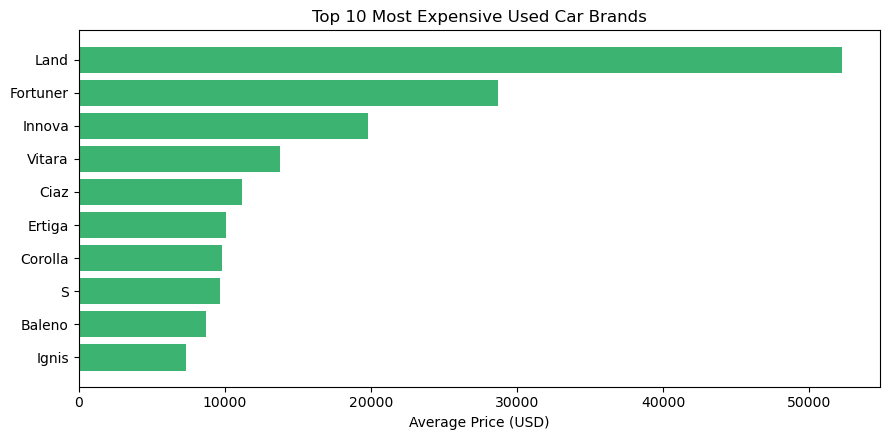

In [39]:
# === 1. Average Price by Brand ===

# Extract the car brand from the 'car_model' column:
# take the first word (usually the brand) and convert it to lowercase
transformed_data["brand"] = transformed_data["car_model"].str.split().str[0].str.lower()

# Group by brand and calculate the average price for each
avg_price_by_brand = transformed_data.groupby("brand")["price"].mean()

# Select the top 10 brands with the highest average prices
top_brands = avg_price_by_brand.sort_values(ascending=False).head(10)

# Print the table with prices rounded to 2 decimal places
print("Top 10 car brands by average price:")
print(top_brands.round(2))

# Build a horizontal bar chart
plt.figure(figsize=(9, 4.5))                                                       # set figure size
plt.barh(top_brands.index.str.title(), top_brands.values, color="mediumseagreen")  # plot bars
plt.xlabel("Average Price (USD)")                                                  # X-axis label
plt.title("Top 10 Most Expensive Used Car Brands")                                 # chart title
plt.gca().invert_yaxis()                                                           # invert Y-axis to show most expensive on top
plt.tight_layout()                                                                 # optimize spacing
plt.savefig("images/top_brands_avg_price.png")                                     # save the chart to file
plt.show()                                                                         # display the chart



## 📊 Chart Summary

The chart displays the **top 10 car models** with the highest average prices.

Many of these models belong to well-known brands:

- **Toyota**: `Fortuner`, `Innova`, `Corolla`, `Etios`  
- **Suzuki**: `Dzire`, `Ritz`, `SX4`

This indicates that **Toyota and Suzuki** dominate among the most expensive used cars, which can be explained by their:

- high reliability  
- market popularity  
- consistent demand even after years of use


## 📈 How Does Year of Manufacture Affect Price?

The next step is to analyze how the average price of cars changes depending on the year of manufacture.

This will help us understand:
- How much a car’s age impacts its market value
- Whether there are specific years that stand out in terms of pricing
- The overall trend of depreciation over time

We'll generate a chart showing the average car price by year of manufacture and save it to the `output` folder.


Average price by year of manufacture:
year_of_manufacture
2003     1940.30
2004     2238.81
2005     4656.72
2006     2649.25
2008     2910.45
2009     4365.67
2010    14639.30
2011     5046.64
2012    11835.82
2013     8922.06
2014     9667.91
2015    12126.87
2016    12113.80
2017    20315.09
2018    13805.97
Name: price, dtype: float64


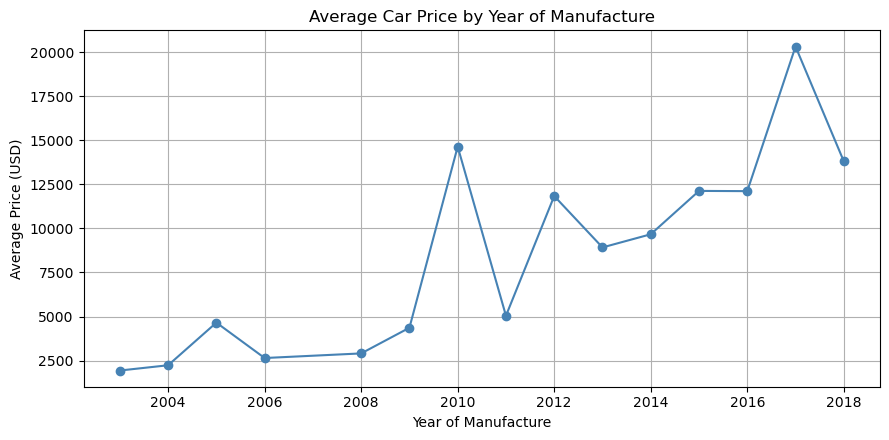

In [40]:
# === 2. Average Price by Year of Manufacture ===

# Group the data by year of manufacture and calculate the average price for each year
avg_price_by_year = transformed_data.groupby("year_of_manufacture")["price"].mean()

# Print the table with average prices by year, rounded to 2 decimal places
print("Average price by year of manufacture:")
print(avg_price_by_year.round(2))

# Create a line chart:
plt.figure(figsize=(9, 4.5))  # set the figure size

# Plot the line: X-axis = year of manufacture, Y-axis = average price
plt.plot(avg_price_by_year.index, avg_price_by_year.values,
         marker="o", linestyle='-', color='steelblue')

# Add title and axis labels
plt.title("Average Car Price by Year of Manufacture")
plt.xlabel("Year of Manufacture")
plt.ylabel("Average Price (USD)")

# Add grid lines for better readability
plt.grid(True)

# Adjust layout to prevent clipping
plt.tight_layout()

# Save the chart to the output folder
plt.savefig("images/avg_price_by_year.png")

# Display the chart
plt.show()



## 🧾 Insights from Visual Analysis

Based on the generated charts, the following conclusions can be drawn:

- **The average price by brand** shows that the most expensive used cars on the market tend to come from brands with strong reputations and consistent demand. Notably, Toyota and Suzuki stand out, with models that retain their value over time.

- **The price trend by year of manufacture** confirms the expected pattern: the newer the vehicle, the higher its average price. Minor fluctuations across years may be explained by the popularity of specific models or market dynamics.

Both charts highlight the importance of **brand** and **year of manufacture** as key factors influencing a vehicle’s market value on the used car market.


---

## ✅ Final Summary of the Project

This project implemented a complete **ETL process** using Python:

1. **Data Extraction:**  
   Loading and combining data from various sources in CSV, JSON, and XML formats.

2. **Data Transformation:**  
   Cleaning and standardizing the data, including rounding prices and simplifying the structure.

3. **Data Load:**  
   Saving the processed dataset into a single CSV file.

After the ETL process, a **visual analysis** was performed, which revealed:

- Which **car brands** are the most expensive on the used market.  
  In particular, models from **Toyota** and **Suzuki** show the highest average prices.

- How **year of manufacture** affects the average car price.  
  The highest prices are observed for cars produced in **2020 and later**, confirming that vehicles depreciate over time.

📊 **The results were visualized and saved** in the `images` folder, making the project not only technically complete but also analytically valuable.

The project demonstrated that even a simple ETL can be a powerful tool for data-driven decision-making.

---

